## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset and test the performance with testing data

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling sklearn.tree.DecisionTreeClassifier

## Load data
The dataset is the Heart Disease Data Set from UCI Machine Learning Repository. It is a binary classifiation dataset, the label is stored in `target` column. **Please note that there exist categorical features which need to be [one-hot encoding](https://www.datacamp.com/community/tutorials/categorical-data) before fit into your model!**
See follow links for more information
https://archive.ics.uci.edu/ml/datasets/heart+Disease

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
df = pd.read_csv(file_url)

train_idx = np.load('train_idx.npy')
test_idx = np.load('test_idx.npy')

train_df = df.iloc[train_idx]
test_df = df.iloc[test_idx]

# remove the noise data
train_df = train_df[train_df["cp"].isin([1, 2, 3, 4])]
train_df = train_df[train_df["thal"].isin(["normal", "fixed", "reversible"])]
test_df = test_df[test_df["cp"].isin([1, 2, 3, 4])]
test_df = test_df[test_df["thal"].isin(["normal", "fixed", "reversible"])]

# one hot encoding for "thal" field
thal_encoded = pd.get_dummies(train_df["thal"], prefix="thal")
train_df = train_df.drop(columns="thal")
train_df = pd.concat([train_df.iloc[:, 0:-1], thal_encoded, train_df.iloc[:, -1]], axis=1)
thal_encoded = pd.get_dummies(test_df["thal"], prefix="thal")
test_df = test_df.drop(columns="thal")
test_df = pd.concat([test_df.iloc[:, 0:-1], thal_encoded, test_df.iloc[:, -1]], axis=1)


In [22]:
train_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal_fixed,thal_normal,thal_reversible,target
264,44,1,4,112,290,0,2,153,0,0.0,1,1,0,1,0,1
140,62,0,4,138,294,1,0,106,0,1.9,2,3,0,1,0,1
104,70,1,4,130,322,0,2,109,0,2.4,2,3,0,1,0,0
290,49,1,3,120,188,0,0,139,0,2.0,2,3,0,0,1,1
262,41,0,2,105,198,0,0,168,0,0.0,1,1,0,1,0,0


In [2]:
X_train = train_df.iloc[:, 0:-1]#.to_numpy()
y_train = train_df.iloc[:, -1]#.to_numpy()
X_test = test_df.iloc[:, 0:-1]#.to_numpy()
y_test = test_df.iloc[:, -1]#.to_numpy()

In [69]:
X_train.columns
#y_train[a]

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal_fixed', 'thal_normal',
       'thal_reversible'],
      dtype='object')

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [3]:
def gini(sequence):
    information = 0
    values, counts = np.unique(sequence, return_counts=True)
    for count in counts:
        information += (count / len(sequence))**2
    return 1 - information

def entropy(sequence):
    information = 0
    values, counts = np.unique(sequence, return_counts=True)
    for count in counts:
        information += -(count / len(sequence)) * np.log2(count / len(sequence))
    return information

In [4]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [5]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [6]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the test data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [7]:
class Node:
    def __init__(self, predicted_result, depth=None):
        self.predicted_result = predicted_result
        self.attribute = ''
        self.threshold = 0
        self.left_node = None
        self.right_node = None
        self.depth = depth

In [8]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None):
        self.criterion = criterion
        self.max_depth = max_depth

    def split_attribute(self, X, y):
        best_attribute = None
        best_threshold = None

        # calculate the information before split
        if self.criterion == 'gini':
            min_info = gini(y.to_numpy())
        else:
            min_info = entropy(y.to_numpy())

        # iterate each attribute in training data
        for attribute in X.columns:
            data = pd.concat([X, y], axis=1)
            sorted_data = data.sort_values(by=[attribute])
            threshold = np.unique(sorted_data[attribute])

            for i in range(1, len(threshold)):
                # split data by threshold
                left_data = sorted_data[sorted_data[attribute] < threshold[i]]
                right_data = sorted_data[sorted_data[attribute] >= threshold[i]]
                left_probability = len(left_data) / len(sorted_data)
                right_probability = len(right_data) / len(sorted_data)

                # get the information of left branch and right branch
                if self.criterion == 'gini':
                    left_info = gini(left_data.iloc[:, -1])
                    right_info = gini(right_data.iloc[:, -1])

                else:
                    left_info = gini(left_data.iloc[:, -1])
                    right_info = gini(right_data.iloc[:, -1])

                total_info = left_probability*left_info + right_probability*right_info
                
                # update the minimum information after split
                if total_info < min_info:
                    min_info = total_info
                    best_attribute = attribute
                    best_threshold = threshold[i]
        
        return best_attribute, best_threshold

    def generate_tree(self, X, y, depth=0):
        # assign the most frequent value in y to the current node's predicted result
        predicated_result = y.mode()[0]
        node = Node(predicated_result, depth)

        if self.max_depth is None or node.depth < self.max_depth:
            attribute, threshold = self.split_attribute(X, y)

            # split the node
            if attribute and threshold:
                self.feature_importance[X.columns.get_loc(attribute)] += 1

                X_left = X[X[attribute] < threshold]
                y_left = y[X_left.index]
                X_right = X[X[attribute] >= threshold]
                y_right = y[X_right.index]

                node.attribute = attribute
                node.threshold = threshold

                # recursively bulid the subtree
                node.left_node = self.generate_tree(X_left, y_left, depth+1)
                node.right_node = self.generate_tree(X_right, y_right, depth+1)
        
        return node

    def fit(self, X, y):
        self.feature_importance = np.zeros(len(X.columns))
        self.root_node = self.generate_tree(X, y)

    def predict(self, X):
        predictions = []

        # predict the result row by row
        for i in range(len(X)):
            node = self.root_node

            # stop when the current node is leaf-node
            while node.left_node:
                if X.iloc[i][node.attribute] < node.threshold:
                    node = node.left_node
                else:
                    node = node.right_node

            predictions.append(node.predicted_result)

        return np.array(predictions)

In [105]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth3.fit(X_train, y_train)

### Question 2.1
Using `criterion=gini`, showing the accuracy score of test data by `max_depth=3` and `max_depth=10`, respectively.


In [14]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)

In [15]:
clf_depth3.fit(X_train, y_train)
print("criterion=gini, max_depth=3, accuracy:", accuracy_score(clf_depth3.predict(X_test), y_test))

clf_depth10.fit(X_train, y_train)
print("criterion=gini, max_depth=10, accuracy:", accuracy_score(clf_depth10.predict(X_test), y_test))

criterion=gini, max_depth=3, accuracy: 0.7835051546391752
criterion=gini, max_depth=10, accuracy: 0.865979381443299


### Question 2.2
Using `max_depth=3`, showing the accuracy score of test data by `criterion=gini` and `criterion=entropy`, respectively.


In [173]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_entropy = DecisionTree(criterion='entropy', max_depth=3)

In [174]:
clf_gini.fit(X_train, y_train)
print("criterion=gini, max_depth=3, accuracy:", accuracy_score(clf_gini.predict(X_test), y_test))

clf_entropy.fit(X_train, y_train)
print("criterion=entropy, max_depth=3, accuracy:", accuracy_score(clf_entropy.predict(X_test), y_test))

criterion=gini, max_depth=3, accuracy: 0.7835051546391752
criterion=entropy, max_depth=3, accuracy: 0.7835051546391752


- Note: All of your accuracy scores should over **0.7**
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

<BarContainer object of 15 artists>

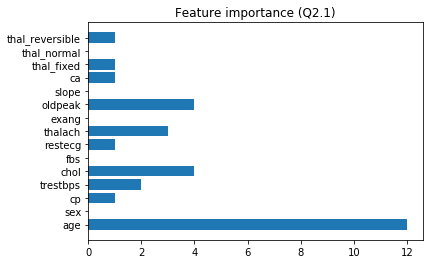

In [13]:
plt.title("Feature importance (Q2.1)")
plt.barh(X_train.columns, clf_depth10.feature_importance)

## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [343]:
class AdaBoost():
    def __init__(self, n_estimators):
        return None

### Question 4.1
Show the accuracy score of test data by `n_estimators=10` and `n_estimators=100`, respectively.


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [175]:
class RandomForest():
    def __init__(self, n_estimators, max_features, bootstrap=True):
        self.n_estimators = n_estimators
        self.max_features = int(max_features)
        self.bootstrap = bootstrap
        self.trees = []

    def build_forest(self, X, y):
        for i in range(self.n_estimators):
            random_attributes = np.random.choice(X.columns, size=self.max_features, replace=False)
            X_train = X[random_attributes]
            y_train = y

            if self.bootstrap:
                X_train = X_train.sample(frac=0.7, replace=False)
                y_train = y_train[X_train.index]
            
            tree = DecisionTree(criterion='gini', max_depth=None)
            tree.fit(X_train, y_train)
            self.trees.append(tree)

    def predict(self, X):
        predictions = []
        voting_results = []
        
        for tree in self.trees:
            prediction = tree.predict(X)
            predictions.append(prediction)

        predictions = np.array(predictions)
        for i in range(len(X)):
            value, counts = np.unique(predictions[:, i], return_counts=True)
            voting = value[np.argmax(counts)]
            voting_results.append(voting)

        return np.array(voting_results)

# clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(len(X_train.columns)))
# clf_10tree.build_forest(X_train, y_train)

In [164]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(len(X_train.columns)))
clf_10tree.build_forest(X_train, y_train)

In [165]:
print("criterion=gini, max_depth=3, accuracy:", accuracy_score(clf_10tree.predict(X_test), y_test))

criterion=gini, max_depth=3, accuracy: 0.8247422680412371


### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of test data by `n_estimators=10` and `n_estimators=100`, respectively.


In [176]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(len(X_train.columns)))
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(len(X_train.columns)))

In [177]:
clf_10tree.build_forest(X_train, y_train)
print("n_estimators=10, max_features=sqrt(n_features), accuracy:", accuracy_score(clf_10tree.predict(X_test), y_test))

clf_100tree.build_forest(X_train, y_train)
print("n_estimators=100, max_features=sqrt(n_features), accuracy:", accuracy_score(clf_100tree.predict(X_test), y_test))

n_estimators=10, max_features=sqrt(n_features), accuracy: 0.865979381443299
n_estimators=100, max_features=sqrt(n_features), accuracy: 0.9072164948453608


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of test data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [13]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(len(X_train.columns)))
clf_all_features = RandomForest(n_estimators=10, max_features=len(X_train.columns))

- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

In [ ]:
clf_random_features.build_forest(X_train, y_train)
print("n_estimators=10, max_features=sqrt(n_features), accuracy:", accuracy_score(clf_random_features.predict(X_test), y_test))

clf_all_features.build_forest(X_train, y_train)
print("n_estimators=10, max_features=n_features, accuracy:", accuracy_score(clf_all_features.predict(X_test), y_test))

### Question 6.
Try you best to get highest test accuracy score by 
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you cannot call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [ ]:
from sklearn.metrics import accuracy_score

In [4]:
y_test = test_df['target']

In [ ]:
y_pred = your_model.predict(x_test)

In [ ]:
print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 